In [1]:
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
from scipy.special import logsumexp
from scipy.special import digamma
%matplotlib inline
#%matplotlib qt5
plt.rcParams.update({'figure.figsize': (10.0, 8.0), 'font.size': 18})

First, We just handcraft some GMM, generate data from it and ML train GMM using standard EM algorithm as a contrastive system

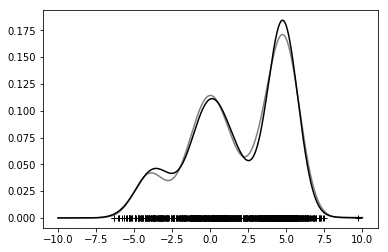

In [7]:
#Handcraft some GMM parameter 
mus = [-4.0, 0.0, 4.0, 5]
sigmas = [1.0, 1.4, 1.2, 1]
pis = [0.1, 0.4, 0.2, 0.3]
t = np.linspace(-10,10,1000)
true_GMM_pdf = sps.norm.pdf(t[:,np.newaxis], mus, sigmas).dot(pis)

# Generate N datapoints from this GMM
N = 1000
Nc = sps.multinomial.rvs(N, pis) # Draw observation counts for each component from multinomial distribution
x = sps.norm.rvs(np.repeat(mus, Nc), np.repeat(sigmas, Nc))
np.random.shuffle(x)

#Choose some initial parameters
C = 6        # number of GMM components 
mus = x[:C]  # we choose few first observations as the initial means
sigmas = np.repeat(np.std(x), C) # sigma for all components is set to std of the the training data
pis = np.ones(C)/C

# Run several iteration of EM algorithm for ML GMM training
for _ in range(1000):
  #E-step
  log_p_xz = sps.norm.logpdf(x[:,np.newaxis], mus, sigmas) + np.log(pis)
  gammas = np.exp(log_p_xz - logsumexp(log_p_xz, axis=1, keepdims=True))

  #M-step
  Nc = gammas.sum(axis=0)
  mus =  x.dot(gammas) / Nc
  sigmas =  np.sqrt((x**2).dot(gammas) / Nc - mus**2) # we use std, not variance!
  pis = Nc / Nc.sum()
    
# Plot the true GMM distribution and ML estimated GMM distribution
EM_GMM_pdf = sps.norm.pdf(t[:,np.newaxis], mus, sigmas).dot(pis)
plt.plot(t, true_GMM_pdf, color='gray');
plt.plot(t, EM_GMM_pdf, 'k');
plt.plot(x, np.zeros_like(x), '+k');

## Gibbs Sampling

In [8]:
# parameters of NormalGamma prior over means and precisiona
m0, kappa0, a0, b0=[0.0, 0.05, 0.05, 0.05] 
alpha0=np.ones(C)

# Lets initialize latent variable z using the responsibilities gammas from EM algorithm
# Random initialization would be fine, but we would need some burn-in Gibbs Sampling itterations
# For convenience, we use one-hot encoding for z
z = np.zeros((len(x), C))
z[np.arange(len(x)), np.argmax(gammas, axis=1)] = 1

def NormalGamma_rvs(m, kappa, a, b, N):
    # Sample from NormalGamma distribution
    lmbd = sps.gamma.rvs(a, scale=1.0/b, size=N)
    mu = sps.norm.rvs(m, 1.0/np.sqrt(lmbd*kappa), N)
    return mu, lmbd

def GMMParamsPosteriorParams(alpha0, m0, kappa0, a0, b0, x, z):
    # Function estimates parameters of posterior distributions of GMM parameters given:
    #   - priors distributions (Dirichlet, NormalGamma)
    #   - observations 'x'
    #   - assignments of frames to gaussians 'z'
    # Input:
    #   alpha0 (C-dim. vector) - parameters of Dirichlet prior for GMM weights
    #   m0, kappa0, a0, b0 (4 scalars) - parameters of NormalGamma prior for Gaussian component params
    #   x (N-dim. vector) - vector of observations
    #   z (NxC matrix) - one-hot encodings assigning observations to Gaussian components
    # Output
    #   alphaN (C-dim. vector) - parameters of Dirichlet posterior for GMM weights
    #   mN, kappaN, aN, bN (4 C-dim. vectors) - parameters of NormalGamma posteriors for all GMM components
    #
    #   We use an alternative formulas for calculating the NormalGamma posteriors!!!
    #   (see function NormalGammaPosteriorParams2 from bayesian_inference_for_gaussian.ipynb)
    N = z.sum(axis=0)
    f =  x.dot(z)
    s =  (x**2).dot(z)
    alphaN = alpha0 + N
    kappaN = kappa0 + N
    mN = (kappa0*m0 + f) / kappaN;
    aN = a0 + 0.5*N;
    bN  = b0 + 0.5 * (s + kappa0 * m0**2 - kappaN * mN**2);
    return alphaN, mN, kappaN, aN, bN


To simulate burn-in, one can re-run the following cell to "reset" the expected_pdf

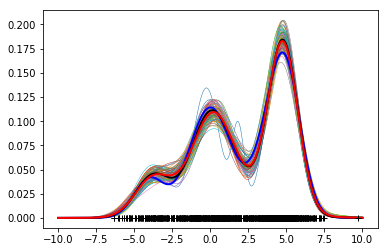

In [9]:
#Iterations of Gibbs sampling
iters = 1000
expected_pdf = 0
for ii in range(iters):
  #Given z, calculate parameters of posterior distributions for all GMM parameters
  alphaN, mN, kappaN, aN, bN = GMMParamsPosteriorParams(alpha0, m0, kappa0, a0, b0, x, z)

  #Given z, sample GMM parameters from NormalGamma posteriors 
  mus, lmbds = NormalGamma_rvs(mN, kappaN, aN, bN, C)
  
  #Given z, sample GMM weights from Dirichlet posteriors
  pis = sps.dirichlet.rvs(alphaN)

  #Given GMM parameters, sample z
  log_p_xz = sps.norm.logpdf(x[:,np.newaxis], mus, sigmas) + np.log(pis)
  gammas = np.exp(log_p_xz - logsumexp(log_p_xz, axis=1, keepdims=True))
  z = np.vstack([sps.multinomial.rvs(1, gamma_n) for gamma_n in gammas])

  #We need to average PDFs of the "sampled GMMs" in order to evaluate the empiricl posterior predictive distribution
  pdf = sps.norm.pdf(t[:,np.newaxis], mus, 1./np.sqrt(lmbds)).dot(pis.T)
  expected_pdf +=  pdf
  if ii % 10 == 0: # plot only every 10-th sampled GMM
        plt.plot(t, pdf, lw=0.5)

#plot the true GMM, ML EM trained GMM and the empiricl posterior predictive distribution
plt.plot(t, true_GMM_pdf, 'b', lw=2);
plt.plot(t, EM_GMM_pdf, 'k', lw=2);
plt.plot(t, expected_pdf/iters, 'r', lw=2);
plt.plot(x, np.zeros_like(x), '+k');

## Collapsed Gibbs Sampling

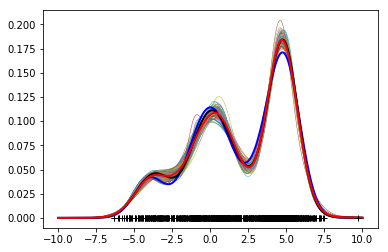

In [10]:
#Iterations of Collapsed Gibbs sampling
plt.figure()
iters = 100
expected_pdf = 0
for ii in range(iters):
  # Given z, posterior predictive distribution is mixture of Student's t-distribution
  alphaN, mN, kappaN, aN, bN = GMMParamsPosteriorParams(alpha0, m0, kappa0, a0, b0, x, z)
  weights = (alphaN)/alphaN.sum()
  pdf = sps.t.pdf(t[:,np.newaxis], loc=mN, df=2*aN, scale=np.sqrt(bN*(kappaN+1)/aN/kappaN)).dot(weights)

  # The PDF that we have evaluated here is the predictive distribution only for a given z. 
  # To approximate "full" posterior predictive distribution, we need to average the PDFs
  # obtained for different samples of z
  expected_pdf += pdf
  if ii % 1 == 0:
    plt.plot(t, pdf, lw=0.5)
  
  # In the inner GS iterations, we ...
  for n in range(len(x)):
    # remove one observation x_i and corresponding z_i
    z[n] = 0
    
    # calculate P(z_i| x_i, x_\i, z_\i), given all remaining observation x_\i and z_\i
    alphaN, mN, kappaN, aN, bN = GMMParamsPosteriorParams(alpha0, m0, kappa0, a0, b0, x, z) #2)
    weights = (alphaN)/alphaN.sum()
    p_zi = sps.t.pdf(x[n], loc=mN, df=2*aN, scale=np.sqrt(bN*(kappaN+1)/aN/kappaN)) * weights
    
    # resample value of z_i using this probability
    z[n] = sps.multinomial.rvs(1, p_zi/p_zi.sum()) #3)
    
#plot the true GMM, ML EM trained GMM and empiricl posterior predictive GMM from GS
plt.plot(t, true_GMM_pdf, 'b', lw=2);
plt.plot(t, EM_GMM_pdf, 'k', lw=2);
plt.plot(t, expected_pdf/iters, 'r', lw=2);
plt.plot(x, np.zeros_like(x), '+k');